## Multi-objective optimization of a dogbone design
---
 Based on "ASTM D638-14: Standard Test Method for Tensile Properties of Plastics 1"
 ASTM D638 Type I test specimen (165x19mm)


In [20]:
# Multi-objective optimization of infill patterns for a dogbone design
# using pymoo optimization library with structural objectives based on
# FEA evaluation in FEniCS framework with Gmsh meshing

import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.termination import get_termination
from pymoo.optimize import minimize

import meshio
import gmsh
from dolfin import *

def create_mesh(mesh, cell_type):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:geometrical", cell_type)
    out_mesh = meshio.Mesh(points=mesh.points[:,:2], cells={cell_type: cells}, cell_data={"name_to_read": [cell_data]})
    return out_mesh


def extract_mesh_data(mesh_to_load):
    msh = meshio.read(mesh_to_load)

    # filepath management
    cwd = Path.cwd()
    temp_dir = cwd.joinpath("temp_mesh")   # temp dir for loading meshes
    temp_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist


    infill_triangles = create_mesh(msh, "triangle")
    infill_lines = create_mesh(msh, "line")
    meshio.write(temp_dir / "mesh.xdmf", infill_triangles)
    meshio.write(temp_dir / "mf.xdmf", infill_lines)

    infill_mesh = Mesh()
    mvc = MeshValueCollection("size_t", infill_mesh, infill_mesh.topology().dim())
    with XDMFFile(str(temp_dir / "mesh.xdmf")) as infile:
        infile.read(infill_mesh)
        infile.read(mvc, "name_to_read")
    cf = cpp.mesh.MeshFunctionSizet(infill_mesh, mvc)

    mvc = MeshValueCollection("size_t", infill_mesh, infill_mesh.topology().dim() - 1)
    with XDMFFile(str(temp_dir / "mf.xdmf")) as infile:
        infile.read(mvc, "name_to_read")
    mf = cpp.mesh.MeshFunctionSizet(infill_mesh, mvc)

    infill_connect = infill_mesh.cells()       # triangle connectivity of the infill mesh
    infill_coords = infill_mesh.coordinates()  # coordinates within the infill mesh
    infill_coords = np.round(infill_coords, 4) # rounding the coordinates
    num_el = len(infill_connect)               # number of infill elements

    return infill_connect, infill_coords, num_el

def extract_mesh_data_fenics(mesh_to_load):
    msh = meshio.read(mesh_to_load)

    # filepath management
    cwd = Path.cwd()
    temp_dir = cwd.joinpath("temp_mesh")   # temp dir for loading meshes
    temp_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist

    triangle_mesh = create_mesh(msh, "triangle")
    line_mesh = create_mesh(msh, "line")
    meshio.write(temp_dir / "mesh.xdmf", triangle_mesh)
    meshio.write(temp_dir / "mf.xdmf", line_mesh)

    mesh = Mesh()
    mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim())
    with XDMFFile(str(temp_dir / "mesh.xdmf")) as infile:
        infile.read(mesh)
        infile.read(mvc, "name_to_read")
    cf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

    mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim() - 1)
    with XDMFFile(str(temp_dir / "mf.xdmf")) as infile:
        infile.read(mvc, "name_to_read")
    mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

    return mesh, mvc, cf, mf

def generate_infill_file(meshpath, infill_vec, infill_connect, infill_coords, verbosity=1, run_GUI=False):

    P = 1.2   # thickness of perimeters in mm
    LO = 165  # overall length
    WO = 19   # width overall
    WN = 13   # narrow section width
    LN = 57   # length of the narrow section
    RF = 76   # radius of the fillet
    G = 50    # gage length (streight length)
    T = 3.2   # thickness
    A = 36.36 # approximated gauge end

    GL = (LO - 50)/2  # gage step (from grip to narrow)
    DF = (WO-WN)/2    # side difference between narrow and grip

    num_el_x, num_el_y = 40, 10  # adjust the num of elements
    dx, dy = LO / num_el_x, WO / num_el_y


    # initialize Gmsh
    if not gmsh.is_initialized():
        gmsh.initialize()
        gmsh.option.setNumber('General.Verbosity', verbosity)

    gmsh.model.add(meshpath.stem)  # "smallSquare8-vecEl-substractive"


    # defining a namespace
    gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
    gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

    # mesh sizes
    lc1 = 2.5*dx   # mesh size grips
    lc2 = 1.5*dx   # mesh size center section

    # defining the points
    gmo.addPoint(0, 0, 0, lc1, 1)
    gmo.addPoint(0, LO, 0, lc1, 2)
    gmo.addPoint(WO, LO, 0, lc1, 3)
    gmo.addPoint(WO, 0, 0, lc1, 4)
    gmo.addPoint(0, A, 0, lc1, 5)
    gmo.addPoint(0, LO-A, 0, lc1, 6)
    gmo.addPoint(WO, LO-A, 0, lc1, 7)
    gmo.addPoint(WO, A, 0, lc1, 8)
    gmo.addPoint(DF, GL, 0, lc2, 9)
    gmo.addPoint(DF, LO-GL, 0, lc2, 10)
    gmo.addPoint(WO-DF, LO-GL, 0, lc2, 11)
    gmo.addPoint(WO-DF, GL, 0, lc2, 12)
    gmo.addPoint(DF-RF, GL, 0, lc1, 13)
    gmo.addPoint(DF-RF,LO-GL, 0, lc1, 14)
    gmo.addPoint(WO-DF+RF, LO-GL, 0, lc1, 15)
    gmo.addPoint(WO-DF+RF, GL, 0, lc1, 16)

    # adding lines
    gmo.addLine(1, 5, 1)
    gmo.addLine(9, 10, 2)
    gmo.addLine(6, 2, 3)
    gmo.addLine(2, 3, 4)
    gmo.addLine(3, 7, 5)
    gmo.addLine(11, 12, 6)
    gmo.addLine(8, 4, 7)
    gmo.addLine(4, 1, 8)

    gmo.addEllipseArc(9, 13, 9, 5, 9)
    gmo.addEllipseArc(10, 14, 10, 6, 10)
    gmo.addEllipseArc(11, 15, 11, 7, 11)
    gmo.addEllipseArc(12, 16, 12, 8, 12)

    # defining a new surface:
    gmo.addCurveLoop([1, -9, 2, 10, 3, 4, 5, -11, 6, 12, 7, 8], 20)
    surf = gmo.addPlaneSurface([20])  # full surface
    # gmo.synchronize()

    # subtracting individual infill elements
    infill_points = []   # list of point tags inside the infill
    for x, y in infill_coords:
        infill_points.append(gmo.addPoint(x, y, 0, lc1))  # add each point

    infill_lines = []   # list of line tags inside the infill
    infill_curves = []  # list of curve tags inside the infill
    infill_surfs = []   # list of surface tags
    for i, tri in enumerate(infill_connect):   # get each point in each triangle
        if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
            p1, p2, p3 = tri[0], tri[1], tri[2]
            tp1 = infill_points[p1]  # tag of p1
            tp2 = infill_points[p2]  # tag of p2
            tp3 = infill_points[p3]  # tag of p3
            l1 = gmo.addLine(tp1, tp2)  # tag of line 1
            l2 = gmo.addLine(tp2, tp3)  # tag of line 2
            l3 = gmo.addLine(tp3, tp1)  # tag of line 3
            xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
            xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
            xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
            infill_lines.append(l1)
            infill_lines.append(l2)
            infill_lines.append(l3)
            c1 = gmo.addCurveLoop([l1, l2, l3])
            s1 = gmo.addPlaneSurface([c1])  # create the surface
            infill_curves.append(c1)
            infill_surfs.append(s1)
    # gmo.synchronize()

    surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
    if len(surfs_to_cut) > 0:
        # substract all in one
        outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
        surf = outlab[0][0][1]
        gmo.synchronize()

    # extract the curve boundary
    Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]

    # adding physical groups
    gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
    gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
    # gmo.synchronize()

    # global meshing options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes


    # generate the mesh
    gmo.synchronize()
    gmsh.model.mesh.generate(2)

    # saving the mesh
    gmsh.write(str(meshpath))

    # Launch the GUI
    if run_GUI:
        gmo.synchronize()
        gmsh.fltk.run()

    # finish the GMSH session
    gmsh.finalize()


def generate_img_file(meshpath, infill_vec, infill_connect, infill_coords, verbosity=1):
    P = 1.2   # thickness of perimeters in mm
    LO = 165  # overall length
    WO = 19   # width overall
    WN = 13   # narrow section width
    LN = 57   # length of the narrow section
    RF = 76   # radius of the fillet
    G = 50    # gage length (streight length)
    T = 3.2   # thickness
    A = 36.36 # approximated gauge end

    GL = (LO - 50)/2  # gage step (from grip to narrow)
    DF = (WO-WN)/2    # side difference between narrow and grip

    num_el_x, num_el_y = 40, 10  # adjust the num of elements
    dx, dy = LO / num_el_x, WO / num_el_y


    # initialize Gmsh
    if not gmsh.is_initialized():
        gmsh.initialize()
        gmsh.option.setNumber('General.Verbosity', verbosity)

    gmsh.model.add(meshpath.stem)  # "smallSquare8-vecEl-substractive"


    # defining a namespace
    gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
    gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

    # mesh sizes
    lc1 = 2.5*dx   # mesh size grips
    lc2 = 1.5*dx   # mesh size center section

    # defining the points
    gmo.addPoint(0, 0, 0, lc1, 1)
    gmo.addPoint(0, LO, 0, lc1, 2)
    gmo.addPoint(WO, LO, 0, lc1, 3)
    gmo.addPoint(WO, 0, 0, lc1, 4)
    gmo.addPoint(0, A, 0, lc1, 5)
    gmo.addPoint(0, LO-A, 0, lc1, 6)
    gmo.addPoint(WO, LO-A, 0, lc1, 7)
    gmo.addPoint(WO, A, 0, lc1, 8)
    gmo.addPoint(DF, GL, 0, lc2, 9)
    gmo.addPoint(DF, LO-GL, 0, lc2, 10)
    gmo.addPoint(WO-DF, LO-GL, 0, lc2, 11)
    gmo.addPoint(WO-DF, GL, 0, lc2, 12)
    gmo.addPoint(DF-RF, GL, 0, lc1, 13)
    gmo.addPoint(DF-RF,LO-GL, 0, lc1, 14)
    gmo.addPoint(WO-DF+RF, LO-GL, 0, lc1, 15)
    gmo.addPoint(WO-DF+RF, GL, 0, lc1, 16)

    # adding lines
    gmo.addLine(1, 5, 1)
    gmo.addLine(9, 10, 2)
    gmo.addLine(6, 2, 3)
    gmo.addLine(2, 3, 4)
    gmo.addLine(3, 7, 5)
    gmo.addLine(11, 12, 6)
    gmo.addLine(8, 4, 7)
    gmo.addLine(4, 1, 8)

    gmo.addEllipseArc(9, 13, 9, 5, 9)
    gmo.addEllipseArc(10, 14, 10, 6, 10)
    gmo.addEllipseArc(11, 15, 11, 7, 11)
    gmo.addEllipseArc(12, 16, 12, 8, 12)

    # defining a new surface:
    gmo.addCurveLoop([1, -9, 2, 10, 3, 4, 5, -11, 6, 12, 7, 8], 20)
    surf = gmo.addPlaneSurface([20])  # full surface
    #gmo.synchronize()

    # subtracting individual infill elements
    infill_points = []   # list of point tags inside the infill
    for x, y in infill_coords:
        infill_points.append(gmo.addPoint(x, y, 0, lc1))  # add each point

    infill_lines = []   # list of line tags inside the infill
    infill_curves = []  # list of curve tags inside the infill
    infill_surfs = []   # list of surface tags
    for i, tri in enumerate(infill_connect):   # get each point in each triangle
        if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
            p1, p2, p3 = tri[0], tri[1], tri[2]
            tp1 = infill_points[p1]  # tag of p1
            tp2 = infill_points[p2]  # tag of p2
            tp3 = infill_points[p3]  # tag of p3
            l1 = gmo.addLine(tp1, tp2)  # tag of line 1
            l2 = gmo.addLine(tp2, tp3)  # tag of line 2
            l3 = gmo.addLine(tp3, tp1)  # tag of line 3
            xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
            xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
            xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
            infill_lines.append(l1)
            infill_lines.append(l2)
            infill_lines.append(l3)
            c1 = gmo.addCurveLoop([l1, l2, l3])
            s1 = gmo.addPlaneSurface([c1])  # create the surface
            infill_curves.append(c1)
            infill_surfs.append(s1)
    gmo.synchronize()

    surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
    if len(surfs_to_cut) > 0:
        # substract all in one
        outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
        surf = outlab[0][0][1]
        gmo.synchronize()

    # extract the curve boundary
    Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]

    # adding physical groups
    gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
    gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
    #gmo.synchronize()

    # global meshing options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes

    # setting up the appearence
    gmsh.option.setNumber("Mesh.ColorCarousel", 0)  # visibility setup
    gmsh.option.setNumber("Mesh.Triangles", 1)      # visibility setup
    gmsh.option.setNumber("Geometry.Points", 0)     # visibility setup
    gmsh.option.setNumber("Mesh.SurfaceFaces", 1)   # visibility setup
    gmsh.option.setNumber("Mesh.Lines", 0)          # visibility setup
    gmsh.option.setNumber("General.SmallAxes", 0)   # visibility setup
    gmsh.option.setNumber("Mesh.LineWidth", 1)      # width setup
    gmsh.option.setNumber("Mesh.Light", 0)          # light setup

    #gmsh.option.setColor("Geometry.Color.Points", 255, 165, 0)  # setting the color
    #gmsh.option.setColor("General.Color.Text", 255, 255, 255)   # setting the color

    gmsh.option.setColor("Mesh.Color.Lines", 210, 200, 185)      # setting the color
    gmsh.option.setColor("Mesh.Color.Triangles", 100, 170, 50)   # setting the color
    gmsh.option.setColor("Geometry.Lines", 100, 170, 50)   # setting the color
    #gmsh.option.setColor("Mesh.SurfaceFaces", 0, 255, 0, 1)
    # gmsh.option.setColor("Mesh.SurfaceFaces", 0, 200, 0, 10)

    # generate the mesh
    gmo.synchronize()
    gmsh.model.mesh.generate(2)

    # Launch the GUI and saving the mesh
    gmsh.fltk.initialize()
    gmsh.write(str(meshpath))

    # close the GUI
    gmsh.fltk.finalize()

    # finish the GMSH session
    gmsh.finalize()

def generate_stl_file(meshpath_stl, infill_vec, infill_connect, infill_coords, verbosity=1, run_GUI=False):

    P = 1.2   # thickness of perimeters in mm
    LO = 165  # overall length
    WO = 19   # width overall
    WN = 13   # narrow section width
    LN = 57   # length of the narrow section
    RF = 76   # radius of the fillet
    G = 50    # gage length (streight length)
    T = 3.2   # thickness
    A = 36.36 # approximated gauge end

    GL = (LO - 50)/2  # gage step (from grip to narrow)
    DF = (WO-WN)/2    # side difference between narrow and grip

    num_el_x, num_el_y = 40, 10  # adjust the num of elements
    dx, dy = LO / num_el_x, WO / num_el_y


    # initialize Gmsh
    if not gmsh.is_initialized():
        gmsh.initialize()
        gmsh.option.setNumber('General.Verbosity', verbosity)

    gmsh.model.add(meshpath_stl.stem)  # add the model


    # defining a namespace
    gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
    gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

    # mesh sizes
    lc1 = 2.5*dx   # mesh size grips
    lc2 = 1.5*dx   # mesh size center section

    # defining the points
    gmo.addPoint(0, 0, 0, lc1, 1)
    gmo.addPoint(0, LO, 0, lc1, 2)
    gmo.addPoint(WO, LO, 0, lc1, 3)
    gmo.addPoint(WO, 0, 0, lc1, 4)
    gmo.addPoint(0, A, 0, lc1, 5)
    gmo.addPoint(0, LO-A, 0, lc1, 6)
    gmo.addPoint(WO, LO-A, 0, lc1, 7)
    gmo.addPoint(WO, A, 0, lc1, 8)
    gmo.addPoint(DF, GL, 0, lc2, 9)
    gmo.addPoint(DF, LO-GL, 0, lc2, 10)
    gmo.addPoint(WO-DF, LO-GL, 0, lc2, 11)
    gmo.addPoint(WO-DF, GL, 0, lc2, 12)
    gmo.addPoint(DF-RF, GL, 0, lc1, 13)
    gmo.addPoint(DF-RF,LO-GL, 0, lc1, 14)
    gmo.addPoint(WO-DF+RF, LO-GL, 0, lc1, 15)
    gmo.addPoint(WO-DF+RF, GL, 0, lc1, 16)

    # adding lines
    gmo.addLine(1, 5, 1)
    gmo.addLine(9, 10, 2)
    gmo.addLine(6, 2, 3)
    gmo.addLine(2, 3, 4)
    gmo.addLine(3, 7, 5)
    gmo.addLine(11, 12, 6)
    gmo.addLine(8, 4, 7)
    gmo.addLine(4, 1, 8)

    gmo.addEllipseArc(9, 13, 9, 5, 9)
    gmo.addEllipseArc(10, 14, 10, 6, 10)
    gmo.addEllipseArc(11, 15, 11, 7, 11)
    gmo.addEllipseArc(12, 16, 12, 8, 12)

    # defining a new surface:
    gmo.addCurveLoop([1, -9, 2, 10, 3, 4, 5, -11, 6, 12, 7, 8], 20)
    surf = gmo.addPlaneSurface([20])  # full surface
    # gmo.synchronize()

    # subtracting individual infill elements
    infill_points = []   # list of point tags inside the infill
    for x, y in infill_coords:
        infill_points.append(gmo.addPoint(x, y, 0, lc1))  # add each point

    infill_lines = []   # list of line tags inside the infill
    infill_curves = []  # list of curve tags inside the infill
    infill_surfs = []   # list of surface tags
    for i, tri in enumerate(infill_connect):   # get each point in each triangle
        if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
            p1, p2, p3 = tri[0], tri[1], tri[2]
            tp1 = infill_points[p1]  # tag of p1
            tp2 = infill_points[p2]  # tag of p2
            tp3 = infill_points[p3]  # tag of p3
            l1 = gmo.addLine(tp1, tp2)  # tag of line 1
            l2 = gmo.addLine(tp2, tp3)  # tag of line 2
            l3 = gmo.addLine(tp3, tp1)  # tag of line 3
            xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
            xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
            xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
            infill_lines.append(l1)
            infill_lines.append(l2)
            infill_lines.append(l3)
            c1 = gmo.addCurveLoop([l1, l2, l3])
            s1 = gmo.addPlaneSurface([c1])  # create the surface
            infill_curves.append(c1)
            infill_surfs.append(s1)
    # gmo.synchronize()

    surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
    if len(surfs_to_cut) > 0:
        # substract all in one
        outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
        surf = outlab[0][0][1]
        gmo.synchronize()

    # extract the curve boundary
    Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]

    # adding physical groups
    gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
    gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
    # gmo.synchronize()

    # Extruding surface
    vol = gmo.extrude([(2,surf)], 0, 0, T)
    vol_surfs = [tg for dm, tg in vol if dm==2]
    #vol_surfs.append(21)
    vol_vols = [tg for dm, tg in vol if dm==3]
    gmo.synchronize()

    #gmsh.model.addPhysicalGroup(1, [1, 3, 4], 5)              # curves physical group
    #print('vol', vol_surfs, vol_vols)
    gmsh.model.addPhysicalGroup(2, vol_surfs, name="SurfaceFaces")  # surfaces physical group
    gmsh.model.addPhysicalGroup(3, vol_vols, name="Volume")  # surfaces physical group

    # global meshing options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes

    # gmsh.model.mesh.setRecombine(2, 21)
    #gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)   # subdivision step alone


    # apply elliptic smoother to the mesh grid:
    # gmsh.option.setNumber("Mesh.Smoothing", 100)

    # generate the mesh
    gmo.synchronize()
    gmsh.model.mesh.generate(2)

    # saving the mesh
    # gmsh.write(str(meshpath))
    gmsh.write(str(meshpath_stl))

    # Launch the GUI
    if run_GUI:
        gmo.synchronize()
        gmsh.fltk.run()

    # finish the GMSH session
    gmsh.finalize()

# load solutions from the txt file
def load_txt_solutions(path_solutions):  # out_dir / "sq_solutions.txt"
    with open(path_solutions, "r") as f:
        lines = f.readlines()
        header = lines[0]
        text = lines[1:]

        X = []
        F1, F2 = [], []
        for line in text:
            sline = line.split('\t')
            vec = sline[0].replace('[','').replace(']','').replace(' ','')
            x = [int(el) for el in vec.split(',')]
            x = np.array(x)

            f1 = sline[1].replace(' ','').split(':')[1]
            f1 = float(f1)
            f2 = sline[2].replace(' ','').split(':')[1]
            f2 = float(f2)

            X.append(x)
            F1.append(f1)
            F2.append(f2)
    F1, F2 = np.array(F1), np.array(F2)
    F = np.vstack((F1, F2)).T
    X = np.vstack(X)
    return F, X


In [21]:
# FEniCS functions setup

# boundary connection setup
tol = 0.1
def clamped_bottom(x, on_boundary): # beam is only fixed on the bottom
    return on_boundary and x[1] < tol

# Define strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

# Define stress
def sigma(u, lambda_, d, mu):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Delta function for point load
class Delta(UserExpression):
    def __init__(self, eps, x0, **kwargs):
        self.eps = eps
        self.x0 = x0
        UserExpression.__init__(self, **kwargs)
    def eval(self, values, x):
        eps = self.eps
        values[0] = 0
        values[1] = eps/pi/(np.linalg.norm(x-self.x0)**2 + eps**2)
    def value_shape(self): return (2, )

# Distrubuted point load above certain height
class Load(UserExpression):
    def __init__(self, **kwargs):
        super().__init__(degree=kwargs["degree"])

        self.height = kwargs['height']
        self.value = kwargs['value']

    def eval(self, value, x):

        if x[1] > self.height:
            value[0] = self.value[0] / 10000
            value[1] = self.value[1] / 10000
        else:
            value[0] = 0
            value[1] = 0

    def value_shape(self):
        return (2,)


# Obtain max, total and average displacements
def get_displacement_measures(u, V):
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, V)
    u_magnitude = u_magnitude.vector()
    disp_len = u_magnitude.size()
    disp_max = u_magnitude.max()   # maximal displacement
    disp_tot = u_magnitude.sum()   # total/sum displacement
    disp_avg = disp_tot / disp_len # average displacement
    return disp_max, disp_tot, disp_avg

# returns displacements and vm stress for side-compression of the square
def dogbone_FEA(mesh, verbose=False, plotting=False):
    if not verbose:
        set_log_active(False)  # dolfin verbose to false
    else:
        set_log_active(True)   # dolfin verbose to true

    # Define function space for system of PDEs
    degree = 2
    lambda_ = 1
    mu = 1
    V = VectorFunctionSpace(mesh, 'P', degree)

    # Define boundary conditions
    bc1 = DirichletBC(V, Constant((0, 0)), clamped_bottom)
    bcs = [bc1]  # combined boundary conditions
    delta = Delta(eps=1E-1, x0=np.array([9.5, 165]), degree=5)  # point load at x0
    load = Load(height=162.5, value=(0, 8), degree=1)

    # Define variational problem
    u = TrialFunction(V)
    d = u.geometric_dimension()   # space dimension
    v = TestFunction(V)
    f = Constant((0, 0))
    T = Constant((0, 0))
    a = inner(sigma(u, lambda_, d, mu), epsilon(v)) * dx
    L = inner(load , v) * dx

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs)

    # Displacement measures
    V1 = FunctionSpace(mesh, 'P', 1)
    disp_max, disp_tot, disp_avg = get_displacement_measures(u, V1)


    # max Von Mises Stress measure
    s = sigma(u, lambda_, d, mu) - (1./3) * tr(sigma(u, lambda_, d, mu)) * Identity(d)  # deviatoric stress
    von_mises = sqrt(3./2 * inner(s, s))
    von_mises = project(von_mises, V1)
    max_von_mises = von_mises.vector().max()  # getting maximal von Mises stress

    if plotting:
        title_str = f"Displacement \n max:{round(disp_max,3)}   tot:{round(disp_tot,3)}   avg:{round(disp_avg,3)} "
        plot(u, title=title_str, mode='displacement')
        plt.show()

        plot(von_mises, title=f"Stress intensity, max vonMis:{round(max_von_mises, 5)}")###
        plt.show()

    return disp_max, disp_tot, disp_avg, max_von_mises


vol [99, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98] [1]
Solving linear variational problem.


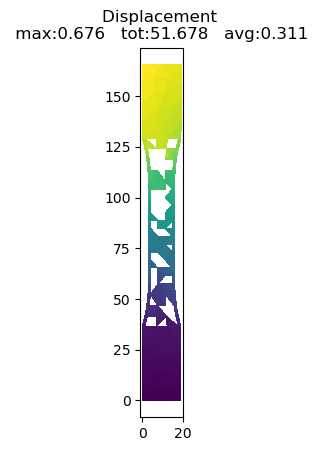

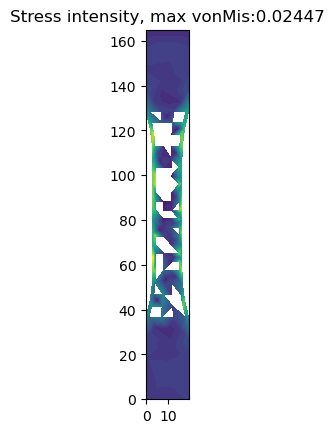

0.676075335075243
0.024466132215887917


In [19]:
# Single iteration from Gmsh meshing to FEniCS in functions
import meshio
import gmsh
from ufl import nabla_div

cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "dogbones")  # adjust the dir here
inf_file = 'dogbone_type1-infill-small.msh'
mesh_inp = mesh_dir / inf_file

# Extracting geometry from the infill mesh
conn, coords, num_el = extract_mesh_data(mesh_inp)

# Create the mesh infill based on the infill vector

vec = np.zeros(num_el)
vec = np.ones(num_el)
vec = np.random.randint(2, size=num_el)
meshfile = mesh_dir / 'infill_gen.msh'
#meshfile_stl = mesh_dir / 'infill_gen.stl'
generate_infill_file(meshfile, vec, conn, coords, run_GUI=False)
#generate_stl_file(meshfile_stl, vec, conn, coords, run_GUI=True)###

# Loading the created infill mesh to FEniCS
mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

# perform FEA and obtain displacements and von mises stress
d_max, d_tot, d_avg, max_vm = dogbone_FEA(mesh, verbose=True, plotting=True)

print(d_max)
print(max_vm)

In [142]:
# Pymoo multi-objective optimization with FEniCS FEA objectives

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.decomposition.asf import ASF


# defining the multiobjective problem for square FEA problem: Weight/vm_stress obj
class MyProblem(ElementwiseProblem):

    def __init__(self, conn, coords, num_el, meshpath):
        super().__init__(n_var=num_el,
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=np.zeros(num_el),
                         xu=np.ones(num_el)
                         )
        self.conn = conn
        self.coords = coords
        self.num_el = num_el
        self.meshpath = meshpath  # temp mesh for evaluation

    def _evaluate(self, x, out, *args, **kwargs):

        # generate the infill file
        generate_infill_file(self.meshpath, x, self.conn, self.coords)

        # Loading the created infill mesh to FEniCS
        mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

        # perform FEA and obtain displacements and von mises stress
        d_max, d_tot, d_avg, max_vm = dogbone_FEA(mesh)

        # objective values: we want to minimize *weight* and *maximal stress*
        f1 = np.sum(x)  # objective 1 - "weight"
        f2 = max_vm     # objective 2 - "maxStress"

        # constraints
        #g1 = np.sum(x) - 200   # dummy constraint: can be adjusted to limit the infill rate

        out["F"] = [f1, f2]  # dictionary key for objectives
        #out["G"] = [g1]      # dictionary key for constraints


# Filepath management
cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "dogbones")  # adjust the dir here
inf_file = 'dogbone_type1-infill.msh'
mesh_inp = mesh_dir / inf_file  # mesh input file

# Extracting geometry from the infill mesh -> num_el is the design dimension
conn, coords, num_el = extract_mesh_data(mesh_inp)   # extracting the geometry

# init the MOP
meshfile = mesh_dir / 'infill_gen.msh'
problem = MyProblem(conn, coords, num_el, meshfile)


# initialize the algorithm object
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=20,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(prob=1.0),
    #crossover=UniformCrossover(),
    mutation=BitflipMutation(prob=0.5, prob_var= 2 * 1/num_el),  # mutation scaled by the num of elements
    eliminate_duplicates=True
)


# define the termination criterion
termination = get_termination("n_gen", 2)


# solve the MOP
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# n_gen  - generation counter,
# n_eval - number of evaluations
# cv_min - minimum constraint violation
# cv_avg - average constraint violation in the current population.
# n_nds  - number of non-dominated solutions
# eps/ind- running performance metrics

X = res.X  # solutions in the decision space
F = res.F  # solutions in the objective space
hist = res.history  # getting the info for each iteration

#print(X)
#print(F)

# save solutions
out_dir = mesh_dir / "infill_gen"
img_dir = out_dir / "png"
out_dir.mkdir(exist_ok=True)
img_dir.mkdir(exist_ok=True)
for i, x in enumerate(X):
    ifile = out_dir / f"sol{i:02d}.msh"  # generate mesh
    generate_infill_file(ifile, x, conn, coords)
    imfile = img_dir / f"sol_{i}.png"    # generate png
    generate_img_file(imfile, x, conn, coords)
    print(f"File {ifile.name} saved.")###

# writing to a file
with open(out_dir / "sq_solutions.txt", "w+") as file:
    alg = str(type(algorithm))[8:-2]
    header = f"Algorithm:{alg}, pop_size: {algorithm.pop_size},\
     n_offsp: {algorithm.n_offsprings}, n_gen: {termination.n_max_gen},\
     t_tot: {res.exec_time:10.1f}, t_gen: {res.exec_time/termination.n_max_gen:10.2f}\n"
    file.writelines(header)
    file.writelines(f"{str(list(sol))} \t w: {F[i][0]:10.1f} \t vm: {F[i][1]:10.06f} \n" for i, sol in enumerate(1*X))

# plotting the decision space
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.imshow(X)
plt.title("Design Space")
plt.show()


# plotting the objective space
plt.figure(figsize=(5, 3))
plt.scatter(F[:, 0], F[:, 1], s=20, facecolors='black', edgecolors='black')
plt.title("Objective Space")
plt.savefig(out_dir / 'ObjectiveSpace.png')
plt.show()


# Multi-Criteria Decision Making: subset selection
n_keep = 9  # how many solutions should we keep
if len(X) > n_keep:
    approx_ideal = F.min(axis=0)  # ideal point
    approx_nadir = F.max(axis=0)  # nadir point

    # normalizing with respect to both objectives
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)  # normalized objectives

    # Decision making: Using Augmented Scalarization Function (ASF)
    decomp = ASF()                  # init the ASF metric to be minimized
    weights = [np.array([(k + 1)/(n_keep+1), (n_keep - k)/(n_keep+1)]) for k in range(n_keep)]
    best_ASF = []  # indexes of chosen solutions
    for weight in weights:
        best_ASF.append(decomp.do(nF, 1/weight).argmin())  # index of the best solution regarding ASF
    best_ASF = list(set(best_ASF))  # remove duplicates
    F_ASF = F[best_ASF, :]          # objectives
    X_ASF = X[best_ASF, :]          # solutions
    n_kept = len(best_ASF)          # number of kept solutions


    # plotting the objective space with mesh png annotations
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.scatter(F_ASF[:, 0], F_ASF[:, 1], s=20, facecolors='black', edgecolors='black')

    for i, (x, y) in enumerate(F_ASF):
        ind = best_ASF[i]
        img_lab = plt.imread(img_dir / f"sol_{ind}.png")
        img_lab = img_lab[150:1150,580:770,:]
        imagebox = OffsetImage(img_lab, zoom=0.12)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (x, y),
                            xybox=(0, 70),
                            xycoords='data',
                            boxcoords=("offset points", "offset points"),
                            pad=-1,
                            )
        ax.add_artist(ab)
        ax.text(x, y, f"  {str(ind)}", va='top', ha='left', zorder=4)

    xrang = np.abs(np.max(F_ASF[:,0]) - np.min(F_ASF[:,0]))
    yrang = np.abs(np.max(F_ASF[:,1]) - np.min(F_ASF[:,1]))
    ax.set_xlim((np.min(F_ASF[:,0]) - 0.05*xrang, np.max(F_ASF[:,0]) + 0.1*xrang ))
    ax.set_ylim((np.min(F_ASF[:,1]) - 0.1*yrang, np.max(F_ASF[:,1]) + 0.5*yrang ))
    plt.title(f"Objective Space of {n_kept} ASF-selected solutions")
    plt.savefig(out_dir / 'ObjectiveSpace-ASF.png')
    plt.show()


KeyboardInterrupt: 

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |     71 |             - |             -
     2 |      170 |     71 |  0.000000E+00 |             f
     3 |      190 |     71 |  0.000000E+00 |             f
     4 |      210 |     71 |  0.000000E+00 |             f
     5 |      230 |     71 |  0.000000E+00 |             f
     6 |      250 |     71 |  0.000000E+00 |             f
     7 |      270 |     71 |  0.000000E+00 |             f
     8 |      290 |     71 |  0.000000E+00 |             f
     9 |      310 |     71 |  0.000000E+00 |             f
    10 |      330 |     71 |  0.000000E+00 |             f
    11 |      350 |     71 |  0.000000E+00 |             f
    12 |      370 |     71 |  0.000000E+00 |             f
    13 |      390 |     71 |  0.000000E+00 |             f
    14 |      410 |     71 |  0.000000E+00 |             f
    15 |      430 |     71 |  0.000000E+00 |             f
    16 |      450 |     72 |  0.000000E+00 |            

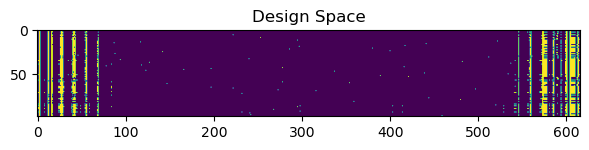

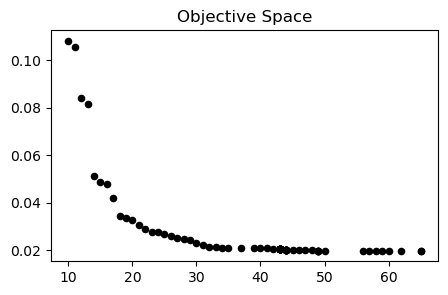

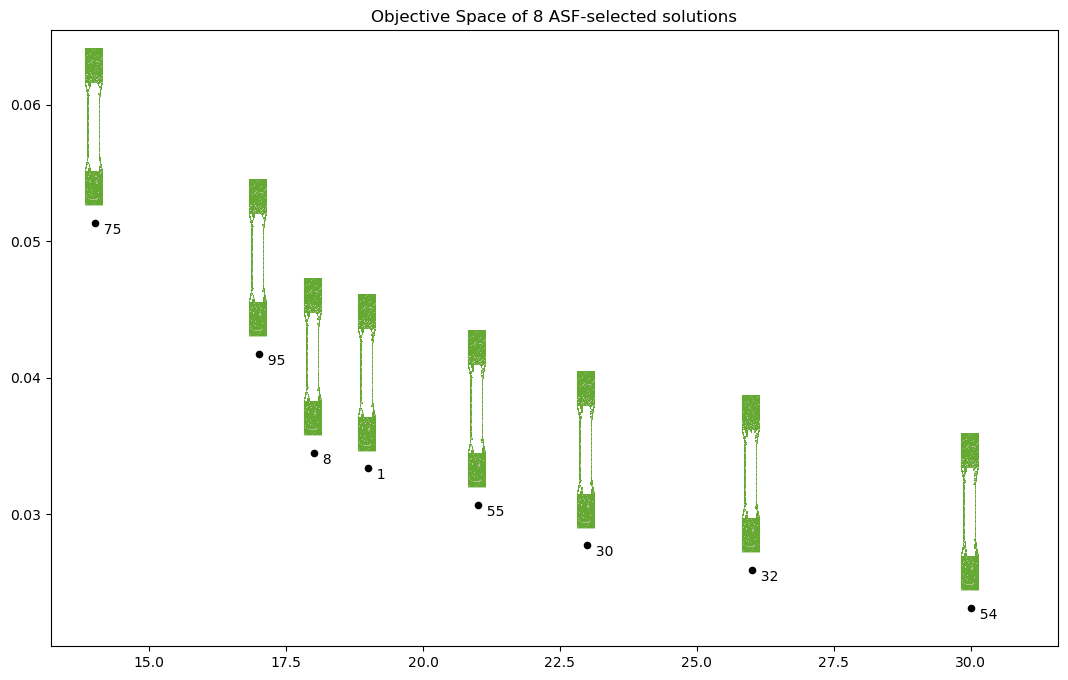

In [13]:
# with PRECOMPUTED sampling implementation (using older solutions)
# Pymoo multi-objective optimization with FEniCS FEA objectives

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.sampling import Sampling

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.decomposition.asf import ASF


# defining the multiobjective problem for square FEA problem: Weight/vm_stress obj
class MyProblem(ElementwiseProblem):

    def __init__(self, conn, coords, num_el, meshpath):
        super().__init__(n_var=num_el,
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=np.zeros(num_el),
                         xu=np.ones(num_el)
                         )
        self.conn = conn
        self.coords = coords
        self.num_el = num_el
        self.meshpath = meshpath  # temp mesh for evaluation

    def _evaluate(self, x, out, *args, **kwargs):

        # generate the infill file
        generate_infill_file(self.meshpath, x, self.conn, self.coords)

        # Loading the created infill mesh to FEniCS
        mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

        # perform FEA and obtain displacements and von mises stress
        d_max, d_tot, d_avg, max_vm = dogbone_FEA(mesh)

        # objective values: we want to minimize *weight* and *maximal stress*
        f1 = np.sum(x)  # objective 1 - "weight"
        f2 = max_vm     # objective 2 - "maxStress"

        # constraints
        #g1 = np.sum(x) - 200   # dummy constraint: can be adjusted to limit the infill rate

        out["F"] = [f1, f2]  # dictionary key for objectives
        #out["G"] = [g1]      # dictionary key for constraints


# Filepath management
cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "dogbones")  # adjust the dir here
inf_file = 'dogbone_type1-infill.msh'
mesh_inp = mesh_dir / inf_file  # mesh input file



####### !!! ####### only for 200 population
# get the precomputed population from a file
X = np.loadtxt(mesh_dir / 'precomputed_solutions.txt', dtype=int)
XX = np.vstack((X,X))   ###
randX = np.random.randint(0, 2, size=(200, 616), dtype=np.int32)  ###
XX[150:, :] = randX[150:, :]   ###
XX = XX.astype('bool')
####### !!! #######





# Extracting geometry from the infill mesh -> num_el is the design dimension
conn, coords, num_el = extract_mesh_data(mesh_inp)   # extracting the geometry

# init the MOP
meshfile = mesh_dir / 'infill_gen.msh'
problem = MyProblem(conn, coords, num_el, meshfile)


# initialize the algorithm object
algorithm = NSGA2(
    pop_size=200,
    n_offsprings=20,
    sampling=XX,
    # sampling=PrecomputedSampling(n_samples=100),
    crossover=TwoPointCrossover(prob=1.0),
    #crossover=UniformCrossover(),
    mutation=BitflipMutation(prob=0.5, prob_var= 6 * 1/num_el),  # mutation scaled by the num of elements
    eliminate_duplicates=True
)


# define the termination criterion
termination = get_termination("n_gen", 2000)


# solve the MOP
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# n_gen  - generation counter,
# n_eval - number of evaluations
# cv_min - minimum constraint violation
# cv_avg - average constraint violation in the current population.
# n_nds  - number of non-dominated solutions
# eps/ind- running performance metrics

X = res.X  # solutions in the decision space
F = res.F  # solutions in the objective space
hist = res.history  # getting the info for each iteration

#print(X)
#print(F)

# save solutions
out_dir = mesh_dir / "infill_gen"
img_dir = out_dir / "png"
out_dir.mkdir(exist_ok=True)
img_dir.mkdir(exist_ok=True)
for i, x in enumerate(X):
    ifile = out_dir / f"sol{i:02d}.msh"  # generate mesh
    generate_infill_file(ifile, x, conn, coords)
    imfile = img_dir / f"sol_{i}.png"    # generate png
    generate_img_file(imfile, x, conn, coords)
    print(f"File {ifile.name} saved.")###

# saving the whole population from the last generation
pop_len = len(res.history[-1].pop)
output_sols = np.zeros((pop_len, num_el))
txt_file = out_dir / 'X_solutions.txt'
for i in range(pop_len):
    sol = res.history[-1].pop[i].X * 1
    output_sols[i, :] = sol[:]
np.savetxt(txt_file, output_sols, fmt='%d')

# writing results to a file
with open(out_dir / "sq_solutions.txt", "w+") as file:
    alg = str(type(algorithm))[8:-2]
    header = f"Algorithm:{alg}, pop_size: {algorithm.pop_size},\
     n_offsp: {algorithm.n_offsprings}, n_gen: {termination.n_max_gen},\
     t_tot: {res.exec_time:10.1f}, t_gen: {res.exec_time/termination.n_max_gen:10.2f}\n"
    file.writelines(header)
    file.writelines(f"{str(list(sol))} \t w: {F[i][0]:10.1f} \t vm: {F[i][1]:10.06f} \n" for i, sol in enumerate(1*X))


# plotting the decision space
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.imshow(X)
plt.title("Design Space")
plt.show()


# plotting the objective space
plt.figure(figsize=(5, 3))
plt.scatter(F[:, 0], F[:, 1], s=20, facecolors='black', edgecolors='black')
plt.title("Objective Space")
plt.savefig(out_dir / 'ObjectiveSpace.png')
plt.show()


# Multi-Criteria Decision Making: subset selection
n_keep = 9  # how many solutions should we keep
if len(X) > n_keep:
    approx_ideal = F.min(axis=0)  # ideal point
    approx_nadir = F.max(axis=0)  # nadir point

    # normalizing with respect to both objectives
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)  # normalized objectives

    # Decision making: Using Augmented Scalarization Function (ASF)
    decomp = ASF()                  # init the ASF metric to be minimized
    weights = [np.array([(k + 1)/(n_keep+1), (n_keep - k)/(n_keep+1)]) for k in range(n_keep)]
    best_ASF = []  # indexes of chosen solutions
    for weight in weights:
        best_ASF.append(decomp.do(nF, 1/weight).argmin())  # index of the best solution regarding ASF
    best_ASF = list(set(best_ASF))  # remove duplicates
    F_ASF = F[best_ASF, :]          # objectives
    X_ASF = X[best_ASF, :]          # solutions
    n_kept = len(best_ASF)          # number of kept solutions


    # plotting the objective space with mesh png annotations
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.scatter(F_ASF[:, 0], F_ASF[:, 1], s=20, facecolors='black', edgecolors='black')

    for i, (x, y) in enumerate(F_ASF):
        ind = best_ASF[i]
        img_lab = plt.imread(img_dir / f"sol_{ind}.png")
        img_lab = img_lab[150:1150,580:770,:]
        imagebox = OffsetImage(img_lab, zoom=0.12)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (x, y),
                            xybox=(0, 70),
                            xycoords='data',
                            boxcoords=("offset points", "offset points"),
                            pad=-1,
                            )
        ax.add_artist(ab)
        ax.text(x, y, f"  {str(ind)}", va='top', ha='left', zorder=4)

    xrang = np.abs(np.max(F_ASF[:,0]) - np.min(F_ASF[:,0]))
    yrang = np.abs(np.max(F_ASF[:,1]) - np.min(F_ASF[:,1]))
    ax.set_xlim((np.min(F_ASF[:,0]) - 0.05*xrang, np.max(F_ASF[:,0]) + 0.1*xrang ))
    ax.set_ylim((np.min(F_ASF[:,1]) - 0.1*yrang, np.max(F_ASF[:,1]) + 0.5*yrang ))
    plt.title(f"Objective Space of {n_kept} ASF-selected solutions")
    plt.savefig(out_dir / 'ObjectiveSpace-ASF.png')
    plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      140 |    100 |  0.000000E+00 |             f
     3 |      180 |    100 |  0.000000E+00 |             f
     4 |      220 |    100 |  0.000000E+00 |             f
     5 |      260 |    100 |  0.000000E+00 |             f
     6 |      300 |    100 |  0.000000E+00 |             f
     7 |      340 |    100 |  0.000000E+00 |             f
     8 |      380 |    100 |  0.000000E+00 |             f
     9 |      420 |    100 |  0.000000E+00 |             f
    10 |      460 |    100 |  0.000000E+00 |             f
    11 |      500 |    100 |  0.000000E+00 |             f
    12 |      540 |    100 |  0.000000E+00 |             f
    13 |      580 |    100 |  0.000000E+00 |             f
    14 |      620 |    100 |  0.000000E+00 |             f
    15 |      660 |    100 |  0.000000E+00 |             f
    16 |      700 |    100 |  0.000000E+00 |            

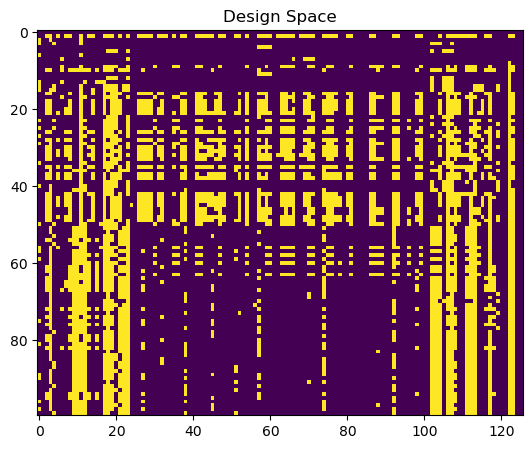

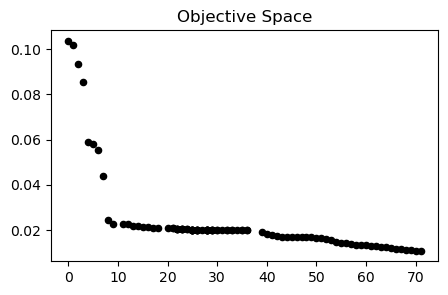

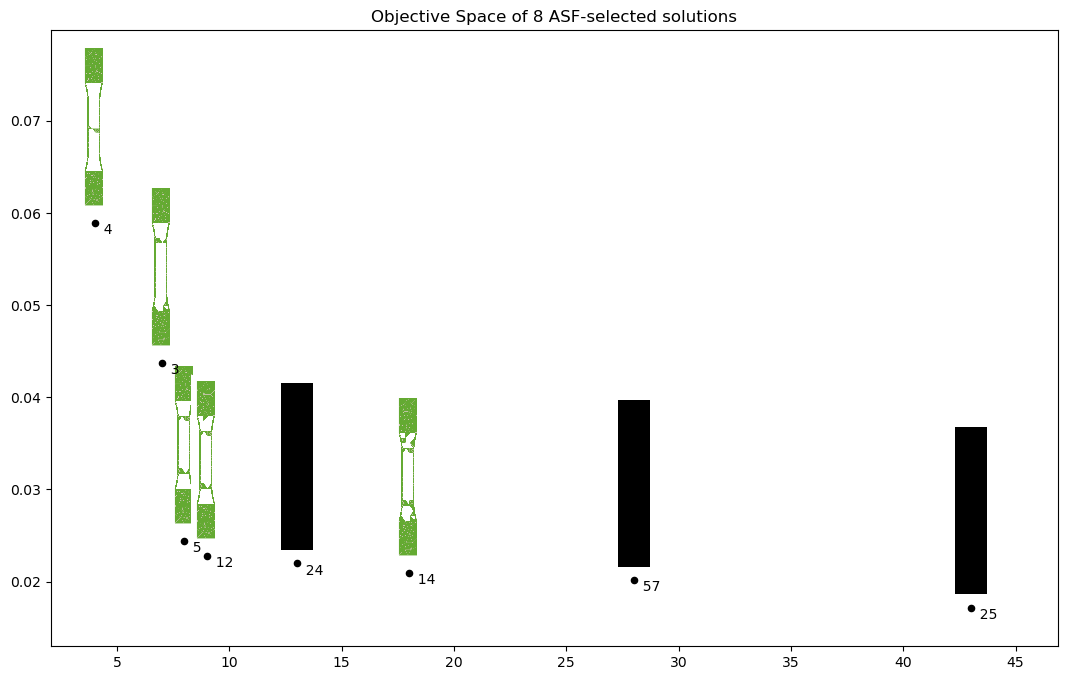

In [11]:
# SMALLER MESH for faster convergence: Pymoo multi-objective optimization with FEniCS FEA objectives

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.decomposition.asf import ASF


# defining the multiobjective problem for square FEA problem: Weight/vm_stress obj
class MyProblem(ElementwiseProblem):

    def __init__(self, conn, coords, num_el, meshpath):
        super().__init__(n_var=num_el,
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=np.zeros(num_el),
                         xu=np.ones(num_el)
                         )
        self.conn = conn
        self.coords = coords
        self.num_el = num_el
        self.meshpath = meshpath  # temp mesh for evaluation

    def _evaluate(self, x, out, *args, **kwargs):

        # generate the infill file
        generate_infill_file(self.meshpath, x, self.conn, self.coords)

        # Loading the created infill mesh to FEniCS
        mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

        # perform FEA and obtain displacements and von mises stress
        d_max, d_tot, d_avg, max_vm = dogbone_FEA(mesh)

        # objective values: we want to minimize *weight* and *maximal stress*
        f1 = np.sum(x)  # objective 1 - "weight"
        f2 = max_vm     # objective 2 - "maxStress"

        # constraints
        #g1 = np.sum(x) - 200   # dummy constraint: can be adjusted to limit the infill rate

        out["F"] = [f1, f2]  # dictionary key for objectives
        #out["G"] = [g1]      # dictionary key for constraints


# Filepath management
cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "dogbones")  # adjust the dir here
inf_file = 'dogbone_type1-infill-small.msh'
mesh_inp = mesh_dir / inf_file  # mesh input file

# get the precomputed population from a file
X = np.loadtxt(mesh_dir / 'precomputed_solutions.txt', dtype=int)
X = X.astype('bool')

# Extracting geometry from the infill mesh -> num_el is the design dimension
conn, coords, num_el = extract_mesh_data(mesh_inp)   # extracting the geometry

# init the MOP
meshfile = mesh_dir / 'infill_gen.msh'
problem = MyProblem(conn, coords, num_el, meshfile)


# initialize the algorithm object
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    #sampling=BinaryRandomSampling(),
    sampling=X,
    crossover=TwoPointCrossover(prob=0.99),
    #crossover=UniformCrossover(),
    mutation=BitflipMutation(prob=0.5, prob_var= 1.5 * 1/num_el),  # mutation scaled by the num of elements
    eliminate_duplicates=True
)


# define the termination criterion
termination = get_termination("n_gen", 4000)


# solve the MOP
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# n_gen  - generation counter,
# n_eval - number of evaluations
# cv_min - minimum constraint violation
# cv_avg - average constraint violation in the current population.
# n_nds  - number of non-dominated solutions
# eps/ind- running performance metrics

X = res.X  # solutions in the decision space
F = res.F  # solutions in the objective space
hist = res.history  # getting the info for each iteration

#print(X)
#print(F)

# output directories
out_dir = mesh_dir / "infill_gen"
img_dir = out_dir / "png"
out_dir.mkdir(exist_ok=True)
img_dir.mkdir(exist_ok=True)

# saving the whole population from the last generation
pop_len = len(hist[-1].pop)
output_sols = np.zeros((pop_len, num_el))
txt_file = out_dir / 'X_solutions.txt'
for i in range(pop_len):
    sol = res.history[-1].pop[i].X * 1
    output_sols[i, :] = sol[:]
np.savetxt(txt_file, output_sols, fmt='%d')

# writing to a file
with open(out_dir / "sq_solutions.txt", "w+") as file:
    alg = str(type(algorithm))[8:-2]
    header = f"Algorithm:{alg}, pop_size: {algorithm.pop_size},\
     n_offsp: {algorithm.n_offsprings}, n_gen: {termination.n_max_gen},\
     t_tot: {res.exec_time:10.1f}, t_gen: {res.exec_time/termination.n_max_gen:10.2f}\n"
    file.writelines(header)
    file.writelines(f"{str(list(sol))} \t w: {F[i][0]:10.1f} \t vm: {F[i][1]:10.06f} \n" for i, sol in enumerate(1*X))

# saving the mesh solutions
for i, x in enumerate(X):
    ifile = out_dir / f"sol{i:02d}.msh"  # generate mesh
    generate_infill_file(ifile, x, conn, coords)
    imfile = img_dir / f"sol_{i}.png"    # generate png
    generate_img_file(imfile, x, conn, coords)
    print(f"File {ifile.name} saved.")

# plotting the decision space
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.imshow(X)
plt.title("Design Space")
plt.show()


# plotting the objective space
plt.figure(figsize=(5, 3))
plt.scatter(F[:, 0], F[:, 1], s=20, facecolors='black', edgecolors='black')
plt.title("Objective Space")
plt.savefig(out_dir / 'ObjectiveSpace.png')
plt.show()


# Multi-Criteria Decision Making: subset selection
n_keep = 9  # how many solutions should we keep
if len(X) > n_keep:
    approx_ideal = F.min(axis=0)  # ideal point
    approx_nadir = F.max(axis=0)  # nadir point

    # normalizing with respect to both objectives
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)  # normalized objectives

    # Decision making: Using Augmented Scalarization Function (ASF)
    decomp = ASF()                  # init the ASF metric to be minimized
    weights = [np.array([(k + 1)/(n_keep+1), (n_keep - k)/(n_keep+1)]) for k in range(n_keep)]
    best_ASF = []  # indexes of chosen solutions
    for weight in weights:
        best_ASF.append(decomp.do(nF, 1/weight).argmin())  # index of the best solution regarding ASF
    best_ASF = list(set(best_ASF))  # remove duplicates
    F_ASF = F[best_ASF, :]          # objectives
    X_ASF = X[best_ASF, :]          # solutions
    n_kept = len(best_ASF)          # number of kept solutions


    # plotting the objective space with mesh png annotations
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.scatter(F_ASF[:, 0], F_ASF[:, 1], s=20, facecolors='black', edgecolors='black')

    for i, (x, y) in enumerate(F_ASF):
        ind = best_ASF[i]
        img_lab = plt.imread(img_dir / f"sol_{ind}.png")
        img_lab = img_lab[150:1150,580:770,:]
        imagebox = OffsetImage(img_lab, zoom=0.12)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (x, y),
                            xybox=(0, 70),
                            xycoords='data',
                            boxcoords=("offset points", "offset points"),
                            pad=-1,
                            )
        ax.add_artist(ab)
        ax.text(x, y, f"  {str(ind)}", va='top', ha='left', zorder=4)

    xrang = np.abs(np.max(F_ASF[:,0]) - np.min(F_ASF[:,0]))
    yrang = np.abs(np.max(F_ASF[:,1]) - np.min(F_ASF[:,1]))
    ax.set_xlim((np.min(F_ASF[:,0]) - 0.05*xrang, np.max(F_ASF[:,0]) + 0.1*xrang ))
    ax.set_ylim((np.min(F_ASF[:,1]) - 0.1*yrang, np.max(F_ASF[:,1]) + 0.5*yrang ))
    plt.title(f"Objective Space of {n_kept} ASF-selected solutions")
    plt.savefig(out_dir / 'ObjectiveSpace-ASF.png')
    plt.show()


In [24]:
# saving the solutions as .stl

cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "dogbones")  # adjust the dir here
out_dir = mesh_dir / "infill_gen"
stl_dir = out_dir / "stl"
stl_dir.mkdir(exist_ok=True)

for i in range(len(X)):
    meshpath_stl = stl_dir / f"sol{i:02d}.stl"
    vec = X[i,:]
    generate_stl_file(meshpath_stl, vec, conn, coords, run_GUI=False)